# Load Data


In [1]:
# Imports
import gzip
import shutil
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

## Create DataFrames


### Create DataFrame from TEP Count Matrix

In [2]:
# Unzip data file (only once)
file_in = 'Data/IntVeld2022/TEP_Count_Matrix.tsv.gz'
file_out = 'Data/IntVeld2022/TEP_Count_Matrix.tsv'

with gzip.open(file_in, 'rb') as f_in:
    with open(file_out, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [3]:
# Read data file into a panda dataframe
data_df = pd.read_csv(file_out, sep='\t')

In [4]:
print(data_df.shape)   # 5440 genes, 2351 samples
data_df.head(5)

(5440, 2351)


,1-Vumc-HD-101-TR922,2-Vumc-HD-103-TR923,3-Vumc-HD-108-TR924,4-Vumc-HD-127-TR925,5-Vumc-HD-130-TR926,6-Vumc-HD-142-TR927,7-Vumc-HD-143-TR928,8-Vumc-HD-144-TR929,9-Vumc-HD-145-TR930,11-Vumc-HD-149-TR932,...,countMatrix.3502-NKI-4854-SARC-TR3080,countMatrix.3503-NKI-4707-SARC-TR3079,countMatrix.3504-NKI-4941-SARC-TR3084,countMatrix.3507-NKI-6348-SARC-TR3134,countMatrix.3508-NKI-5275-SARC-TR3099,countMatrix.3512-NKI-5148-SARC-TR3129,countMatrix.320-10,countMatrix.327-34,countMatrix.376-P-PH-001-013-TR1400,countMatrix.506-NKI-NSCLC-107-270
ENSG00000000419,5,79,58,128,93,12,0,0,18,28,...,3,0,1,2,9,16,22,21,0,1
ENSG00000000460,8,10,21,14,6,8,25,42,5,7,...,0,3,0,2,63,3,3,0,1,0
ENSG00000000938,24,336,334,59,120,22,31,13,19,36,...,8,45,1,7,163,90,46,75,14,8
ENSG00000001036,38,46,15,36,25,43,27,27,59,5,...,1,3,4,15,3,6,10,8,3,0
ENSG00000001461,72,17,11,9,18,28,5,6,49,18,...,1,1,0,0,12,2,6,6,1,0


In [5]:
list_of_genes = data_df.index
#list_of_genes

In [6]:
# Read GFF3
file='GFF3.csv'
df_GFF3 = pd.read_csv(file,sep=';',na_values='n.a.',index_col=0)
df_GFF3.index = df_GFF3['gene']
print(df_GFF3.shape)
df_GFF3.head(5)

(196520, 3)


,transcript,gene,transcriptLength
gene,,,
ENSG00000223972,ENST00000456328,ENSG00000223972,1654.0
ENSG00000223972,ENST00000515242,ENSG00000223972,1650.0
ENSG00000223972,ENST00000518655,ENSG00000223972,1479.0
ENSG00000223972,ENST00000450305,ENSG00000223972,626.0
ENSG00000227232,ENST00000438504,ENSG00000227232,1771.0


In [7]:
# Check how many transcripts we have per gene
# We will choose min, max or mean length to normalize afterwards

# 1) Create sublist
df_GFF3_sublist = df_GFF3.loc[list_of_genes,:]
df_GFF3_sublist.shape

(59087, 3)

In [8]:
df_GFF3_sublist.head(10)

,transcript,gene,transcriptLength
ENSG00000000419,ENST00000371588,ENSG00000000419,1066.0
ENSG00000000419,ENST00000466152,ENSG00000000419,1088.0
ENSG00000000419,ENST00000371582,ENSG00000000419,1151.0
ENSG00000000419,ENST00000494752,ENSG00000000419,782.0
ENSG00000000419,ENST00000371584,ENSG00000000419,1063.0
ENSG00000000419,ENST00000371583,ENSG00000000419,947.0
ENSG00000000419,ENST00000413082,ENSG00000000419,664.0
ENSG00000000460,ENST00000498289,ENSG00000000460,3820.0
ENSG00000000460,ENST00000472795,ENSG00000000460,913.0
ENSG00000000460,ENST00000413811,ENSG00000000460,1686.0


In [9]:
# 2) Compute how many transcripts per gene
df_GFF3_sublist.groupby('gene').count()
df_GFF3_sublist.groupby('gene').count().describe()

,transcript,transcriptLength
count,5440.000000,5440.000000
mean,10.861581,10.861581
std,7.309721,7.309721
min,1.000000,1.000000
25%,6.000000,6.000000
50%,9.000000,9.000000
75%,14.000000,14.000000
max,82.000000,82.000000


Each gene has between 1 and 82 transcripts. 

We don't know which transcript has been measured. We will have to choose which one we will use: the shortest, the longest, the mean length...

In [10]:
df_GFF3_sublist.head(5)

,transcript,gene,transcriptLength
ENSG00000000419,ENST00000371588,ENSG00000000419,1066.0
ENSG00000000419,ENST00000466152,ENSG00000000419,1088.0
ENSG00000000419,ENST00000371582,ENSG00000000419,1151.0
ENSG00000000419,ENST00000494752,ENSG00000000419,782.0
ENSG00000000419,ENST00000371584,ENSG00000000419,1063.0


In [11]:
# Decission: let's create a datafame with:
# *** index: list of genes present and 
# *** length: take the mean transcript length
df_genes_maxlength = df_GFF3_sublist.groupby('gene').mean()

C:\Users\Edel\AppData\Local\Temp\ipykernel_72744\3369723814.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_genes_maxlength = df_GFF3_sublist.groupby('gene').mean()


In [12]:
# df_genes_maxlength.drop('transcript', axis=1, inplace=True) 

In [13]:
print(df_genes_maxlength.shape)
df_genes_maxlength.head(5)

(5440, 1)


,transcriptLength
gene,
ENSG00000000419,965.857143
ENSG00000000460,2182.200000
ENSG00000000938,1789.000000
ENSG00000001036,1306.500000
ENSG00000001461,1947.875000


In [14]:
data_df_present = data_df.copy(deep=True)
print(data_df_present.shape)
data_df_present.head(2)

(5440, 2351)


,1-Vumc-HD-101-TR922,2-Vumc-HD-103-TR923,3-Vumc-HD-108-TR924,4-Vumc-HD-127-TR925,5-Vumc-HD-130-TR926,6-Vumc-HD-142-TR927,7-Vumc-HD-143-TR928,8-Vumc-HD-144-TR929,9-Vumc-HD-145-TR930,11-Vumc-HD-149-TR932,...,countMatrix.3502-NKI-4854-SARC-TR3080,countMatrix.3503-NKI-4707-SARC-TR3079,countMatrix.3504-NKI-4941-SARC-TR3084,countMatrix.3507-NKI-6348-SARC-TR3134,countMatrix.3508-NKI-5275-SARC-TR3099,countMatrix.3512-NKI-5148-SARC-TR3129,countMatrix.320-10,countMatrix.327-34,countMatrix.376-P-PH-001-013-TR1400,countMatrix.506-NKI-NSCLC-107-270
ENSG00000000419,5,79,58,128,93,12,0,0,18,28,...,3,0,1,2,9,16,22,21,0,1
ENSG00000000460,8,10,21,14,6,8,25,42,5,7,...,0,3,0,2,63,3,3,0,1,0


In [15]:
# Add information about length
data_df_present_wLength = pd.merge(df_genes_maxlength, data_df_present, left_index=True, right_index=True, how='inner')


In [16]:
data_df_present_wLength.head(5)

,transcriptLength,1-Vumc-HD-101-TR922,2-Vumc-HD-103-TR923,3-Vumc-HD-108-TR924,4-Vumc-HD-127-TR925,5-Vumc-HD-130-TR926,6-Vumc-HD-142-TR927,7-Vumc-HD-143-TR928,8-Vumc-HD-144-TR929,9-Vumc-HD-145-TR930,...,countMatrix.3502-NKI-4854-SARC-TR3080,countMatrix.3503-NKI-4707-SARC-TR3079,countMatrix.3504-NKI-4941-SARC-TR3084,countMatrix.3507-NKI-6348-SARC-TR3134,countMatrix.3508-NKI-5275-SARC-TR3099,countMatrix.3512-NKI-5148-SARC-TR3129,countMatrix.320-10,countMatrix.327-34,countMatrix.376-P-PH-001-013-TR1400,countMatrix.506-NKI-NSCLC-107-270
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000000419,965.857143,5,79,58,128,93,12,0,0,18,...,3,0,1,2,9,16,22,21,0,1
ENSG00000000460,2182.200000,8,10,21,14,6,8,25,42,5,...,0,3,0,2,63,3,3,0,1,0
ENSG00000000938,1789.000000,24,336,334,59,120,22,31,13,19,...,8,45,1,7,163,90,46,75,14,8
ENSG00000001036,1306.500000,38,46,15,36,25,43,27,27,59,...,1,3,4,15,3,6,10,8,3,0
ENSG00000001461,1947.875000,72,17,11,9,18,28,5,6,49,...,1,1,0,0,12,2,6,6,1,0


In [17]:
col_names = list(data_df_present_wLength.columns)
print(col_names.index("transcriptLength"))
col_names

0


['transcriptLength',
 '1-Vumc-HD-101-TR922',
 '2-Vumc-HD-103-TR923',
 '3-Vumc-HD-108-TR924',
 '4-Vumc-HD-127-TR925',
 '5-Vumc-HD-130-TR926',
 '6-Vumc-HD-142-TR927',
 '7-Vumc-HD-143-TR928',
 '8-Vumc-HD-144-TR929',
 '9-Vumc-HD-145-TR930',
 '11-Vumc-HD-149-TR932',
 '12-Vumc-HD-151-TR933',
 '13-Vumc-HD-155-TR934',
 '14-Vumc-HD-156-TR935',
 '15-Vumc-HD-56-TR884',
 '16-Vumc-HD-60-TR885',
 '17-Vumc-HD-63-TR886',
 '18-Vumc-HD-73-TR887',
 '19-Vumc-HD-74-TR888',
 '20-Vumc-HD-80-TR889',
 '21-Vumc-HD-81-TR890',
 '22-Vumc-HD-83-TR891',
 '23-Vumc-HD-84-TR892',
 '24-Vumc-HD-86-TR893',
 '25-Vumc-HD-87-TR894',
 '26-Vumc-HD-88-TR895',
 '27-Vumc-HD-89-TR896',
 '28-Vumc-HD-91-TR897',
 '29-Vumc-HD-92-TR920',
 '30-Vumc-HD-98-TR921',
 '31-AMC-HD-001-TR1139',
 '32-AMC-HD-002-TR1140',
 '33-AMC-HD-003-TR1141',
 '34-AMC-HD-004-TR1142',
 '35-AMC-HD-005-TR1143',
 '36-AMC-HD-006-TR1144',
 '37-AMC-HD-007-TR1145',
 '38-AMC-HD-008-TR1146',
 '39-AMC-HD-010-TR1147',
 '40-Vumc-HD-100-TR1095',
 '41-Vumc-HD-102-TR1096',
 '

In [18]:
# Apply TPM
# Step 1: Normalize for gene length (K)
# For each row, divide each element by transcript length
col_names = list(data_df_present_wLength.columns)
# print(col_names)
data_df_present_wLength = data_df_present_wLength[col_names[1:]].div(data_df_present_wLength[col_names[0]], axis = 0)
data_df_present_wLength.head(5)

,1-Vumc-HD-101-TR922,2-Vumc-HD-103-TR923,3-Vumc-HD-108-TR924,4-Vumc-HD-127-TR925,5-Vumc-HD-130-TR926,6-Vumc-HD-142-TR927,7-Vumc-HD-143-TR928,8-Vumc-HD-144-TR929,9-Vumc-HD-145-TR930,11-Vumc-HD-149-TR932,...,countMatrix.3502-NKI-4854-SARC-TR3080,countMatrix.3503-NKI-4707-SARC-TR3079,countMatrix.3504-NKI-4941-SARC-TR3084,countMatrix.3507-NKI-6348-SARC-TR3134,countMatrix.3508-NKI-5275-SARC-TR3099,countMatrix.3512-NKI-5148-SARC-TR3129,countMatrix.320-10,countMatrix.327-34,countMatrix.376-P-PH-001-013-TR1400,countMatrix.506-NKI-NSCLC-107-270
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000000419,0.005177,0.081793,0.060050,0.132525,0.096288,0.012424,0.000000,0.000000,0.018636,0.028990,...,0.003106,0.000000,0.001035,0.002071,0.009318,0.016566,0.022778,0.021742,0.000000,0.001035
ENSG00000000460,0.003666,0.004583,0.009623,0.006416,0.002750,0.003666,0.011456,0.019247,0.002291,0.003208,...,0.000000,0.001375,0.000000,0.000917,0.028870,0.001375,0.001375,0.000000,0.000458,0.000000
ENSG00000000938,0.013415,0.187814,0.186696,0.032979,0.067077,0.012297,0.017328,0.007267,0.010620,0.020123,...,0.004472,0.025154,0.000559,0.003913,0.091112,0.050307,0.025713,0.041923,0.007826,0.004472
ENSG00000001036,0.029085,0.035209,0.011481,0.027555,0.019135,0.032912,0.020666,0.020666,0.045159,0.003827,...,0.000765,0.002296,0.003062,0.011481,0.002296,0.004592,0.007654,0.006123,0.002296,0.000000
ENSG00000001461,0.036963,0.008727,0.005647,0.004620,0.009241,0.014375,0.002567,0.003080,0.025156,0.009241,...,0.000513,0.000513,0.000000,0.000000,0.006161,0.001027,0.003080,0.003080,0.000513,0.000000


In [19]:
# Step 2: Normalize for sequencing depth (M)
# For each column: 
#    sum all entries and divide by 10^6
#    then, divide each element by the above number
data_df_present_wLength_with_depth = data_df_present_wLength.copy(deep=True)

data_df_present_wLength_with_depth = data_df_present_wLength_with_depth.transform(lambda x: (x*10**6)/x.sum())

data_df_present_wLength_with_depth.head(5)


,1-Vumc-HD-101-TR922,2-Vumc-HD-103-TR923,3-Vumc-HD-108-TR924,4-Vumc-HD-127-TR925,5-Vumc-HD-130-TR926,6-Vumc-HD-142-TR927,7-Vumc-HD-143-TR928,8-Vumc-HD-144-TR929,9-Vumc-HD-145-TR930,11-Vumc-HD-149-TR932,...,countMatrix.3502-NKI-4854-SARC-TR3080,countMatrix.3503-NKI-4707-SARC-TR3079,countMatrix.3504-NKI-4941-SARC-TR3084,countMatrix.3507-NKI-6348-SARC-TR3134,countMatrix.3508-NKI-5275-SARC-TR3099,countMatrix.3512-NKI-5148-SARC-TR3129,countMatrix.320-10,countMatrix.327-34,countMatrix.376-P-PH-001-013-TR1400,countMatrix.506-NKI-NSCLC-107-270
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000000419,2.600465,50.805676,59.851792,118.794644,70.682138,7.114463,0.000000,0.000000,9.215628,22.955747,...,70.361743,0.000000,19.839919,5.709039,27.861056,72.107216,77.702154,75.897049,0.000000,15.280839
ENSG00000000460,1.841574,2.846450,9.591506,5.750866,2.018349,2.099274,6.325651,14.116148,1.133028,2.540094,...,0.000000,13.381914,0.000000,2.526861,86.320501,5.984093,4.689753,0.000000,3.396495,0.000000
ENSG00000000938,6.738989,116.661344,186.079352,29.562520,49.239148,7.041839,9.567779,5.329598,5.251805,15.934501,...,101.299634,244.846390,10.711307,10.787818,272.423909,218.979678,87.714373,146.342144,58.002039,65.999363
ENSG00000001036,14.610599,21.869883,11.443106,24.699768,14.046568,18.846591,11.410749,15.157089,22.330988,3.030448,...,17.338791,22.351330,58.668283,31.653939,6.865621,19.990032,26.110420,21.374653,17.019132,0.000000
ENSG00000001461,18.568005,5.421081,5.628513,4.141725,6.783457,8.231343,1.417323,2.259184,12.439426,7.317415,...,11.629663,4.997243,0.000000,0.000000,18.419936,4.469311,10.507840,10.752480,3.805086,0.000000


In [ ]:
data_df = data_df_present_wLength_with_depth.T

In [ ]:
display(data_df.sample(5))

gene,ENSG00000000419,ENSG00000000460,ENSG00000000938,ENSG00000001036,ENSG00000001461,ENSG00000001497,ENSG00000001629,ENSG00000001631,ENSG00000002330,ENSG00000002549,...,ENSG00000267279,ENSG00000267316,ENSG00000268555,ENSG00000269028,ENSG00000270055,ENSG00000271043,ENSG00000272053,ENSG00000272168,ENSG00000272369,ENSG00000272888
2472-Vumc-NSCLC-393-TR2478,0.000000,12.768477,12.743043,1.938794,1.300409,1.013281,9.503968,13.359222,31.833458,2.452589,...,51.357672,113.728046,68.926088,116.832764,8.623094,19.560106,261.442627,8.276198,34.153264,13.129062
650-Vumc-LGG-VU473-TR510,0.000000,0.595744,17.440344,4.975248,8.008927,0.520048,22.762760,11.998650,16.337928,17.622436,...,58.364955,254.700207,69.644588,298.535388,3.872437,82.820591,300.007456,21.238020,70.114102,28.300634
175-Vumc-HD-265-TR1868,40.807104,7.388801,396.561764,46.622493,18.394793,27.233191,24.646849,48.423933,50.658387,137.036688,...,23.350964,102.373593,3.046833,72.083467,9.148278,17.292837,130.832853,8.780255,24.155567,44.571778
3052-MGH-OVARY-602-TR562,0.000000,3.278938,8.726417,11.451265,16.697213,1.821470,11.796300,6.432452,45.983331,35.899937,...,49.928354,115.493683,54.206805,368.329656,3.321608,85.391415,515.571639,6.110304,16.079322,17.531987
2629-UMCG-NSCLC-1005-TR2795,54.932527,0.000000,95.950203,26.277063,0.000000,9.987861,7.806678,10.287593,39.222602,54.393853,...,27.119465,25.477538,55.732115,321.594539,1.328084,114.476777,154.986290,8.922601,35.067398,19.411877


In [ ]:
print(data_df.shape)
gens = data_df.columns
pacients = data_df.index
print(gens[:10])
print(pacients[:10])

(2351, 5440)
Index(['ENSG00000000419', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000001036', 'ENSG00000001461', 'ENSG00000001497',
       'ENSG00000001629', 'ENSG00000001631', 'ENSG00000002330',
       'ENSG00000002549'],
      dtype='object', name='gene')
Index(['1-Vumc-HD-101-TR922', '2-Vumc-HD-103-TR923', '3-Vumc-HD-108-TR924',
       '4-Vumc-HD-127-TR925', '5-Vumc-HD-130-TR926', '6-Vumc-HD-142-TR927',
       '7-Vumc-HD-143-TR928', '8-Vumc-HD-144-TR929', '9-Vumc-HD-145-TR930',
       '11-Vumc-HD-149-TR932'],
      dtype='object')


In [ ]:
# Verify data type, Naans etc
# print(data_df.info())
# print(data_df.describe())

In [ ]:
# data_df.dtypes
data_df.isnull().values.any()
# data_df.isnull().sum()

False

### Create DataFrame from metadata (ground truth)

#### Txt

In [ ]:
file = 'IntVeld2022_metadata.txt'

with open (file, "r") as f:
    y_data = f.read().splitlines()

In [ ]:
ys_data = []
line = 0

# Change names to match those in the excel file
Group_txt = ['Asymptomatic Controls', 'Pancreatic Disease', 'Urothelial Carcinoma', 'Epilepsy', 'Esophageal Cancer', 'Renal Cell Carcinoma', 'Hodgkin Lymphoma']
Group_xml = ['Asymptomatic controls', 'Pancreatic diseases', 'Urothelial cancer', 'Medically-intractable epilepsy', 'Esophageal carcinoma', 'Renal Cell cancer', 'Lymphoma']


while line < len(y_data):
    if y_data[line]:
        if y_data[line][0].isdigit(): 
            Patient = re.split('[0-9]+: ', y_data[line])[1]
            Class_group = re.split('"',y_data[line+6])[1]
            Patient_group = re.split('"',y_data[line+7])[1]
            if Patient_group in Group_txt:
                Patient_group = Group_xml[Group_txt.index(Patient_group)]
            ys_data.append([Patient,Class_group,Patient_group])
            line += 9
    line += 1

print(len(ys_data))
print(ys_data[0])

2351
['NKI-NSCLC-4861-TR2958', 'Malignant', 'Non-Small-Cell Lung Cancer']


In [ ]:
y_df = pd.DataFrame(ys_data, columns=['Sample ID', 'Class_group','Patient_group'])
y_df.sample(5)

,Sample ID,Class_group,Patient_group
2027,TR3477-HD-NKI,nonMalignant,Asymptomatic controls
287,NKI-NSCLC-2932-TR2231,Malignant,Non-Small-Cell Lung Cancer
1545,TR4047-OVA-Supernat,Malignant,Endometrial Cancer
874,TR4378-OVA-GDANSK,Malignant,Ovarian Cancer
1003,Vumc-EPI-VU627t0-TR2134,nonMalignant,Medically-intractable epilepsy


In [ ]:
y_df.shape

(2351, 3)

In [ ]:
Class_group_values = y_df['Class_group'].unique()
print("Class_group_values: ", Class_group_values)

Patient_group_values_Malignant = y_df.loc[y_df['Class_group'] == 'Malignant','Patient_group'].unique()
print("\nPatient_group_values_Malignant: ", sorted(list(Patient_group_values_Malignant)))
print("Total Patient_group_values_Malignant: ", len(Patient_group_values_Malignant))

print("Number of Malignant samples: " , len(y_df.loc[y_df['Class_group'] == 'Malignant']))
# print(y_df.loc[y_df['Class_group'] == 'Malignant'].groupby(by='Patient_group').count())

Patient_group_values_nonMalignant = y_df.loc[y_df['Class_group'] == 'nonMalignant','Patient_group'].unique()
print("\nPatient_group_values_nonMalignant: ", sorted(list(Patient_group_values_nonMalignant)))
print("Total Patient_group_values_nonMalignant: ", len(Patient_group_values_nonMalignant))

print("Number of non Malignant samples: " , len(y_df.loc[y_df['Class_group'] == 'nonMalignant']))
# print(y_df.loc[y_df['Class_group'] == 'nonMalignant'].groupby(by='Patient_group').count())

Class_group_values:  ['Malignant' 'nonMalignant']

Patient_group_values_Malignant:  ['Asymptomatic controls', 'Breast Cancer', 'Cholangiocarcinoma', 'Colorectal Cancer', 'Endometrial Cancer', 'Esophageal carcinoma', 'Glioma', 'Head and Neck Cancer', 'Hepatocellular Carcinoma', 'Lymphoma', 'Melanoma', 'Multiple Myeloma', 'Non-Small-Cell Lung Cancer', 'Ovarian Cancer', 'Pancreatic Cancer', 'Prostate Cancer', 'Renal Cell cancer', 'Sarcoma', 'Urothelial cancer']
Total Patient_group_values_Malignant:  19
Number of Malignant samples:  1648

Patient_group_values_nonMalignant:  ['Angina Pectoris', 'Asymptomatic controls', 'Bowel Disease', 'Former Sarcoma', 'Hematuria', 'Medically-intractable epilepsy', 'Multiple Sclerosis', 'Pancreatic diseases', 'Prostate Cancer', 'Pulmonary Hypertension', 'nSTEMI']
Total Patient_group_values_nonMalignant:  11
Number of non Malignant samples:  703


In [ ]:
filtered_y_df = y_df[(y_df['Class_group']=='Malignant') & (y_df['Patient_group']=='Asymptomatic controls') ]
# print(filtered_y_df)
print("Number of samples Malignant + Asymtomatic controls: ", len(filtered_y_df))

Number of samples Malignant + Asymtomatic controls:  21


In [ ]:
filtered_y_df = y_df[(y_df['Class_group']=='nonMalignant') & (y_df['Patient_group']=='Prostate Cancer') ]
# print(filtered_y_df)
print("Number of samples nonMalignant + Prostate Cancer: ", len(filtered_y_df))

Number of samples nonMalignant + Prostate Cancer:  1


In [ ]:
# Correct incorrect data
y_df.loc[(y_df['Class_group']=='nonMalignant') & (y_df['Patient_group'] == 'Prostate Cancer'), 'Class_group'] = 'Malignant'
y_df.loc[(y_df['Class_group']=='Malignant') & (y_df['Patient_group'] == 'Asymptomatic controls'), 'Class_group'] = 'nonMalignant'


In [ ]:
print("Number of Malignant samples: " , len(y_df.loc[y_df['Class_group'] == 'Malignant']))
print("Number of non Malignant samples: " , len(y_df.loc[y_df['Class_group'] == 'nonMalignant']))

Number of Malignant samples:  1628
Number of non Malignant samples:  723


In [ ]:
print(y_df.loc[y_df['Class_group'] == 'Malignant'].groupby(by='Patient_group').count())

                            Sample ID  Class_group
Patient_group                                     
Breast Cancer                      93           93
Cholangiocarcinoma                 85           85
Colorectal Cancer                  85           85
Endometrial Cancer                 39           39
Esophageal carcinoma               15           15
Glioma                            132          132
Head and Neck Cancer              101          101
Hepatocellular Carcinoma           23           23
Lymphoma                           20           20
Melanoma                           68           68
Multiple Myeloma                   31           31
Non-Small-Cell Lung Cancer        522          522
Ovarian Cancer                    144          144
Pancreatic Cancer                 126          126
Prostate Cancer                    35           35
Renal Cell cancer                  28           28
Sarcoma                            53           53
Urothelial cancer              

In [ ]:
print(y_df.loc[y_df['Class_group'] == 'nonMalignant'].groupby(by='Patient_group').count())

                                Sample ID  Class_group
Patient_group                                         
Angina Pectoris                        26           26
Asymptomatic controls                 391          391
Bowel Disease                           9            9
Former Sarcoma                         26           26
Hematuria                               5            5
Medically-intractable epilepsy         44           44
Multiple Sclerosis                     86           86
Pancreatic diseases                    50           50
Pulmonary Hypertension                 71           71
nSTEMI                                 15           15


#### XLSX

In [ ]:
# Add information about age, sex, cancer stage and supplying institutions
# Compare data between xlsx and txt and correct some information

# pip install openpyxl
file = '1-s2.0-S1535610822003701-mmc3.xlsx'
y_xlsx_df = pd.read_excel(file, header=2)

In [ ]:
y_xlsx_df.head(5)

,Sample ID,Group,Stage,Sex,Age,Sample-supplying institution,Training series,Evaluation series,Validation series,lib.size,classificationScoreCancer
0,Vumc-HD-101-TR922,Asymptomatic controls,n.a.,F,35,Institute 13,1,0,0,2296824,0.485949
1,Vumc-HD-103-TR923,Asymptomatic controls,n.a.,F,54,Institute 13,0,1,0,1731594,0.370735
2,Vumc-HD-108-TR924,Asymptomatic controls,n.a.,F,56,Institute 13,0,0,1,1136912,0.799796
3,Vumc-HD-127-TR925,Asymptomatic controls,n.a.,F,52,Institute 13,1,0,0,1115322,0.580309
4,Vumc-HD-130-TR926,Asymptomatic controls,n.a.,F,57,Institute 13,0,1,0,1331137,0.402155


In [ ]:
y_xlsx_df.replace('n.a.', np.nan, inplace=True)

In [ ]:
y_xlsx_df.isnull().values.any()

True

In [ ]:
# Check which columns have Nan values
list_na_columns = y_xlsx_df.columns[y_xlsx_df.isna().any()].tolist()
print(list_na_columns)


['Stage', 'Sex', 'Age']


In [ ]:
y_merged_df = pd.merge(y_xlsx_df, y_df, on=['Sample ID'], how='inner')
y_merged_df.shape

(2351, 13)

In [ ]:
y_merged_df.head(5)

,Sample ID,Group,Stage,Sex,Age,Sample-supplying institution,Training series,Evaluation series,Validation series,lib.size,classificationScoreCancer,Class_group,Patient_group
0,Vumc-HD-101-TR922,Asymptomatic controls,NaN,F,35.0,Institute 13,1,0,0,2296824,0.485949,nonMalignant,Asymptomatic controls
1,Vumc-HD-103-TR923,Asymptomatic controls,NaN,F,54.0,Institute 13,0,1,0,1731594,0.370735,nonMalignant,Asymptomatic controls
2,Vumc-HD-108-TR924,Asymptomatic controls,NaN,F,56.0,Institute 13,0,0,1,1136912,0.799796,nonMalignant,Asymptomatic controls
3,Vumc-HD-127-TR925,Asymptomatic controls,NaN,F,52.0,Institute 13,1,0,0,1115322,0.580309,nonMalignant,Asymptomatic controls
4,Vumc-HD-130-TR926,Asymptomatic controls,NaN,F,57.0,Institute 13,0,1,0,1331137,0.402155,nonMalignant,Asymptomatic controls


In [ ]:
# Find differences and change values

# mergedStuff[mergedStuff["Group"].astype(str).str.lower() != mergedStuff["Patient_group"].astype(str).str.lower()].groupby('Patient_group').count()
y_merged_df[y_merged_df["Group"].astype(str).str.lower() != y_merged_df["Patient_group"].astype(str).str.lower()]

,Sample ID,Group,Stage,Sex,Age,Sample-supplying institution,Training series,Evaluation series,Validation series,lib.size,classificationScoreCancer,Class_group,Patient_group
2318,Vumc-P-PH-001-024-TR1414,Pulmonary Hypertension,NaN,M,71.0,Institute 13,0,0,1,464882,0.949583,nonMalignant,Asymptomatic controls


In [ ]:
y_merged_df.loc[y_merged_df["Group"].astype(str).str.lower() != y_merged_df["Patient_group"].astype(str).str.lower(),'Patient_group'] = 'Pulmonary Hypertension'
# mergedStuff[mergedStuff["Sample ID"] == 'Vumc-P-PH-001-024-TR1414']

In [ ]:
# Review numbers and compare with article
y_merged_df.groupby('Class_group').size()

Class_group
Malignant       1628
nonMalignant     723
dtype: int64

In [ ]:
types_of_cancers = y_merged_df[y_merged_df['Class_group'] == 'Malignant'].groupby(by='Patient_group').size()
print(types_of_cancers)
print("Total number of cancers: ", len(types_of_cancers))

Patient_group
Breast Cancer                  93
Cholangiocarcinoma             85
Colorectal Cancer              85
Endometrial Cancer             39
Esophageal carcinoma           15
Glioma                        132
Head and Neck Cancer          101
Hepatocellular Carcinoma       23
Lymphoma                       20
Melanoma                       68
Multiple Myeloma               31
Non-Small-Cell Lung Cancer    522
Ovarian Cancer                144
Pancreatic Cancer             126
Prostate Cancer                35
Renal Cell cancer              28
Sarcoma                        53
Urothelial cancer              28
dtype: int64
Total number of cancers:  18


In [ ]:
types_of_nonCancers = y_merged_df[y_merged_df['Class_group'] == 'nonMalignant'].groupby(by='Patient_group').size()
print(types_of_nonCancers)
print("Total number of categories of nonMalignant patients (apart from Asymptomatic controls): ", len(types_of_nonCancers) - 1)

Patient_group
Angina Pectoris                    26
Asymptomatic controls             390
Bowel Disease                       9
Former Sarcoma                     26
Hematuria                           5
Medically-intractable epilepsy     44
Multiple Sclerosis                 86
Pancreatic diseases                50
Pulmonary Hypertension             72
nSTEMI                             15
dtype: int64
Total number of categories of nonMalignant patients (apart from Asymptomatic controls):  9


In [ ]:
# Article: For a subset of samples, tumor stages were unknown (n.a.; n = 124) or not informative (n.i.; e.g.,
# gliomas and multiple myeloma; n = 132; in total n = 256; 16% of all cancers).
stage_of_cancers = y_merged_df[y_merged_df['Class_group'] == 'Malignant'].groupby(by='Stage').size()
print(stage_of_cancers)

stage_of_cancers_glioma = y_merged_df[y_merged_df['Patient_group'] == 'Glioma'].groupby(by='Stage').size()
print("\n",stage_of_cancers_glioma)


Stage
I      111
II     166
III    235
IV     860
dtype: int64

 Series([], dtype: int64)


In [ ]:
# Correct data: nonMalignant should not have Stage
y_merged_df.loc[(~y_merged_df['Stage'].isna()) & (y_merged_df['Class_group']=='nonMalignant')]


,Sample ID,Group,Stage,Sex,Age,Sample-supplying institution,Training series,Evaluation series,Validation series,lib.size,classificationScoreCancer,Class_group,Patient_group
789,Vumc-ChronPan-29-TR1045,Pancreatic diseases,IV,M,58.0,Institute 13,0,0,1,1504224,0.946398,nonMalignant,Pancreatic diseases


In [ ]:
y_merged_df.loc[(~y_merged_df['Stage'].isna()) & (y_merged_df['Class_group']=='nonMalignant'),'Stage'] = np.nan

In [ ]:
y_merged_df.loc[(~y_merged_df['Stage'].isna()) & (y_merged_df['Class_group']=='nonMalignant')]

,Sample ID,Group,Stage,Sex,Age,Sample-supplying institution,Training series,Evaluation series,Validation series,lib.size,classificationScoreCancer,Class_group,Patient_group


In [ ]:
# Remove columns that are repeated or irrelevant
y_merged_df.drop('Group', axis=1, inplace=True)
y_merged_df.drop('lib.size', axis=1, inplace=True)
y_merged_df.drop('classificationScoreCancer', axis=1, inplace=True)
y_merged_df.sample(5)

,Sample ID,Stage,Sex,Age,Sample-supplying institution,Training series,Evaluation series,Validation series,Class_group,Patient_group
1566,Vumc-NSCLC-388-TR2477,III,M,68.0,Institute 13,0,0,1,Malignant,Non-Small-Cell Lung Cancer
1883,TR4043-OVA-GDANSK,II,F,62.0,Institute 2,0,1,0,Malignant,Ovarian Cancer
267,Vienna-CRC-Vien-23-TR3008,NaN,F,29.0,Institute 12,0,1,0,nonMalignant,Asymptomatic controls
209,RAD-HIV-HV325-1-TR1963,NaN,M,56.0,Institute 8,0,1,0,nonMalignant,Asymptomatic controls
730,MGH-H-146-Breast-TR3181,II,F,65.0,Institute 4,0,0,1,Malignant,Breast Cancer


In [ ]:
y_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2351 entries, 0 to 2350
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Sample ID                     2351 non-null   object 
 1   Stage                         1372 non-null   object 
 2   Sex                           2331 non-null   object 
 3   Age                           2328 non-null   float64
 4   Sample-supplying institution  2351 non-null   object 
 5   Training series               2351 non-null   int64  
 6   Evaluation series             2351 non-null   int64  
 7   Validation series             2351 non-null   int64  
 8   Class_group                   2351 non-null   object 
 9   Patient_group                 2351 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 202.0+ KB


### Combine DataFrames containing info about platelets and ground truth


In [ ]:
patients_d = list(data_df.index)
print(patients_d[:10])
print(len(patients_d))

patients_y = list(y_merged_df['Sample ID'])
print(patients_y[:10])
print(len(patients_y))

['1-Vumc-HD-101-TR922', '2-Vumc-HD-103-TR923', '3-Vumc-HD-108-TR924', '4-Vumc-HD-127-TR925', '5-Vumc-HD-130-TR926', '6-Vumc-HD-142-TR927', '7-Vumc-HD-143-TR928', '8-Vumc-HD-144-TR929', '9-Vumc-HD-145-TR930', '11-Vumc-HD-149-TR932']
2351
['Vumc-HD-101-TR922', 'Vumc-HD-103-TR923', 'Vumc-HD-108-TR924', 'Vumc-HD-127-TR925', 'Vumc-HD-130-TR926', 'Vumc-HD-142-TR927', 'Vumc-HD-143-TR928', 'Vumc-HD-144-TR929', 'Vumc-HD-145-TR930', 'Vumc-HD-149-TR932']
2351


In [ ]:
compare_patients = [ x.find(y)!=-1 for (x,y) in zip(patients_d, patients_y)]
print("Number of patients: ", len(compare_patients), "Number of name coincidences",  sum(compare_patients), "For example: ", patients_d[0], " and ", patients_y[0])

print("\nCases where names are not simmilar: ")
different_patients =  [ x.find(y)==-1 for (x,y) in zip(patients_d, patients_y)]
different_patients_index = [i for i, x in enumerate(different_patients) if x]
for idx in different_patients_index:
    print(patients_d[idx], "and ", end='')
    print(patients_y[idx])

Number of patients:  2351 Number of name coincidences 2348 For example:  1-Vumc-HD-101-TR922  and  Vumc-HD-101-TR922

Cases where names are not simmilar: 
countMatrix.320-10 and Vumc-P-PH-001-010-TR1505
countMatrix.327-34 and Vumc-P-PH-001-034-TR1512
countMatrix.506-NKI-NSCLC-107-270 and NKI-NSCLC-107-270-TR725


In [ ]:
# We assume both databases have same list of patients and in the same order.
# Therefore, we can join them

y_merged_df.index = patients_d
df = pd.merge(data_df, y_merged_df, left_index=True, right_index=True, how='inner')

In [ ]:
# df.head(5)
# display(df)
print(df.shape)

(2351, 5450)


In [ ]:
# Check which columns have Nan values
list_na_columns = df.columns[df.isna().any()].tolist()
print(list_na_columns)

# df['Age'].describe()
# df['Age'].dtype       # float64
# df.loc[df['Age'] == 18]

# df['Age'].isnull().values.any()
# df.isnull().values.any()

# df['Stage'].isna().sum()
# df['Stage'].describe()

print(df['Stage'].isnull().sum())
print(df['Sex'].isnull().sum())
print(df['Age'].isnull().sum())

['Stage', 'Sex', 'Age']
979
20
23


In [ ]:
# Save merged dataFrame
file='DataFrame_Merged.csv'
df.to_csv(file, sep=';', na_rep='n.a.')

## Exploratory Analysis

### Missing data

In [ ]:
# Read merged dataFrame
file='DataFrame_Merged.csv'

df = pd.read_csv(file,sep=';',index_col=0, na_values='n.a.', dtype={'Stage': 'object', 'Age': 'float64'})

In [ ]:
print(df.shape)

(2351, 5450)


In [ ]:
# Missing data
list_na_columns = df.columns[df.isna().any()].tolist()
print("Columns with Nans", list_na_columns)

Columns with Nans ['Stage', 'Sex', 'Age']


In [ ]:
print("Number of Nans in Stage: ", df['Stage'].isna().sum()) # 723 non-malig + 256 malig
print("Number of Nans in Sex: ", df['Sex'].isna().sum())
print("Number of Nans in Age: ", df['Age'].isna().sum())

Number of Nans in Stage:  979
Number of Nans in Sex:  20
Number of Nans in Age:  23


### Data range and variance

In [ ]:
list_columns = df.columns
print(list_columns)

Index(['ENSG00000000419', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000001036', 'ENSG00000001461', 'ENSG00000001497',
       'ENSG00000001629', 'ENSG00000001631', 'ENSG00000002330',
       'ENSG00000002549',
       ...
       'Sample ID', 'Stage', 'Sex', 'Age', 'Sample-supplying institution',
       'Training series', 'Evaluation series', 'Validation series',
       'Class_group', 'Patient_group'],
      dtype='object', length=5450)


In [ ]:
# Data range and variance for Assymptomatic
# Mean values

df_asymptomatic = df.loc[df['Patient_group']=='Asymptomatic controls']

# mean_column = df_asymptomatic.mean(numeric_only=True)
# mean_gens = mean_column[:5440]
# print("Max mean value: ", mean_gens.max())
# print("Min mean value: ", mean_gens.min())

# fig, ax = plt.subplots(figsize=(10, 4))
# fig.suptitle(t="Mean gene values", fontsize=15)
# sns.kdeplot(mean_gens, shade=True)
# plt.show()

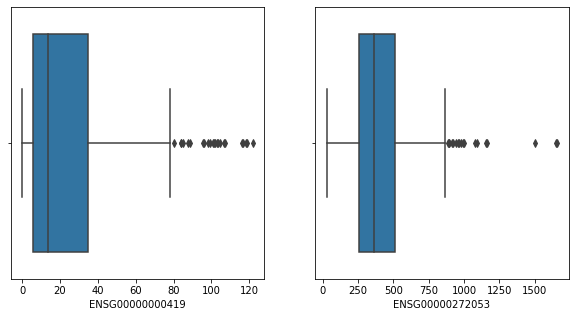

In [ ]:
# Outliers
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(x=df_asymptomatic['ENSG00000000419'], ax=ax[0])
sns.boxplot(x=df_asymptomatic['ENSG00000272053'], ax=ax[1])
plt.show()

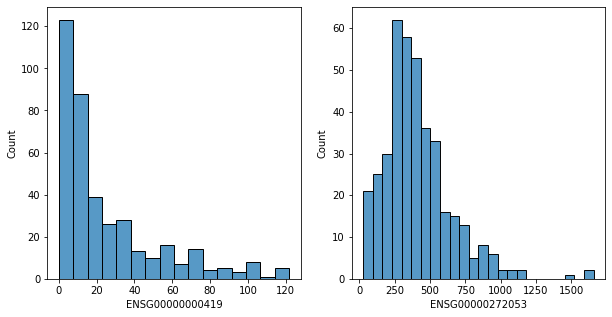

In [ ]:
# Another way of visualizing them
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(df_asymptomatic, x="ENSG00000000419", ax=ax[0])
sns.histplot(df_asymptomatic, x='ENSG00000272053', ax=ax[1])
plt.show()

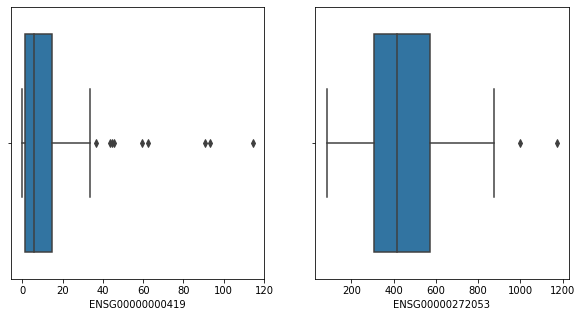

In [ ]:
# Idem colorectal cancer
df_colorectal = df.loc[df['Patient_group']=='Colorectal Cancer']

# Outliers
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(x=df_colorectal['ENSG00000000419'], ax=ax[0])
sns.boxplot(x=df_colorectal['ENSG00000272053'], ax=ax[1])
plt.show()

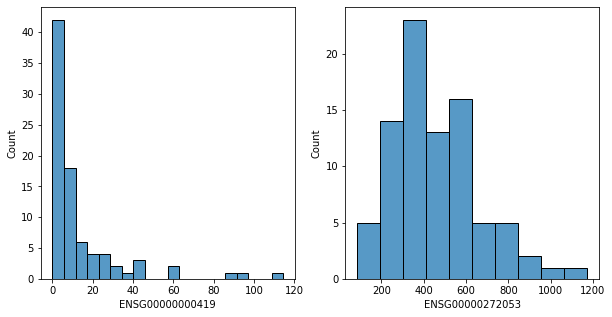

In [ ]:
# Another way of visualizing them
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(df_colorectal, x="ENSG00000000419", ax=ax[0])
sns.histplot(df_colorectal, x='ENSG00000272053', ax=ax[1])
plt.show()

In [ ]:
# df.describe()

### Sample-Supplying institutions impact

Article: We noticed slightly different platelet RNA compositions from asymptomatic controls between the different sample-supplying institutions. To minimize this effect, we included data correction steps and followed a step-by-step standardized protocol.

In [ ]:
df.head(1)

,ENSG00000000419,ENSG00000000460,ENSG00000000938,ENSG00000001036,ENSG00000001461,ENSG00000001497,ENSG00000001629,ENSG00000001631,ENSG00000002330,ENSG00000002549,...,Sample ID,Stage,Sex,Age,Sample-supplying institution,Training series,Evaluation series,Validation series,Class_group,Patient_group
1-Vumc-HD-101-TR922,2.600465,1.841574,6.738989,14.610599,18.568005,2.009476,13.507501,9.272612,40.245457,32.587602,...,Vumc-HD-101-TR922,NaN,F,35.0,Institute 13,1,0,0,nonMalignant,Asymptomatic controls


In [ ]:
df_asymptomatic = df.loc[df['Patient_group']=='Asymptomatic controls']
df_asymptomatic.shape

(390, 5450)

In [ ]:
df_asymptomatic.groupby(by='Sample-supplying institution').mean()

,ENSG00000000419,ENSG00000000460,ENSG00000000938,ENSG00000001036,ENSG00000001461,ENSG00000001497,ENSG00000001629,ENSG00000001631,ENSG00000002330,ENSG00000002549,...,ENSG00000270055,ENSG00000271043,ENSG00000272053,ENSG00000272168,ENSG00000272369,ENSG00000272888,Age,Training series,Evaluation series,Validation series
Sample-supplying institution,,,,,,,,,,,,,,,,,,,,,
Institute 1,14.905495,3.481689,15.029472,14.594397,5.692623,1.397026,6.144052,12.401331,40.915217,19.541523,...,6.374455,195.810822,641.883838,14.738698,85.036904,23.224702,24.888889,0.333333,0.333333,0.333333
Institute 10,16.509735,3.608400,35.296771,18.319411,9.589949,2.804508,22.014338,11.441779,43.198988,30.453910,...,5.730735,168.860565,427.553378,13.890671,59.210828,28.506267,52.178571,0.142857,0.142857,0.714286
Institute 11,14.745039,4.943005,37.192275,27.160052,11.503326,4.969060,11.800327,17.576642,28.045389,55.576468,...,4.370627,0.787842,265.958068,13.195569,40.371974,22.075486,33.000000,0.000000,0.000000,1.000000
Institute 12,11.729719,9.071329,57.533599,20.956335,12.542404,6.599497,19.758865,16.458202,35.128541,46.653922,...,8.609676,119.788074,491.503632,13.094001,65.045936,27.326244,31.000000,0.400000,0.400000,0.200000
Institute 13,21.880829,5.924250,66.471858,21.368227,13.073749,5.610504,15.654209,18.726401,42.289705,57.434890,...,8.593381,63.279675,427.655846,11.453794,49.519355,30.539225,48.280156,0.337037,0.340741,0.322222
Institute 3,10.708505,6.126904,16.251744,21.298993,12.184351,2.247797,15.420952,11.923639,36.578834,34.432635,...,9.555875,5.738112,568.291055,11.254921,36.839763,27.064495,65.523810,0.000000,0.000000,1.000000
Institute 5,73.236319,6.952617,393.808087,43.013228,26.118821,28.991785,22.809958,51.246189,31.384936,169.955956,...,2.484480,1.032465,131.608498,3.294148,12.534181,23.949257,53.527778,0.472222,0.527778,0.000000
Institute 8,16.522262,7.783220,41.224049,20.613646,12.537654,5.293788,18.222682,20.406788,48.673513,58.249142,...,9.247847,86.677316,401.983662,12.809878,51.717102,32.820226,54.363636,0.363636,0.272727,0.363636


In [ ]:
df_colorectal = df.loc[df['Patient_group']=='Colorectal Cancer']
print(df_colorectal.shape)
df_colorectal.groupby(by='Sample-supplying institution').mean()

(85, 5450)


,ENSG00000000419,ENSG00000000460,ENSG00000000938,ENSG00000001036,ENSG00000001461,ENSG00000001497,ENSG00000001629,ENSG00000001631,ENSG00000002330,ENSG00000002549,...,ENSG00000270055,ENSG00000271043,ENSG00000272053,ENSG00000272168,ENSG00000272369,ENSG00000272888,Age,Training series,Evaluation series,Validation series
Sample-supplying institution,,,,,,,,,,,,,,,,,,,,,
Institute 12,10.255448,3.796973,39.775111,18.399254,9.705327,2.660333,10.706131,9.699901,35.236061,34.491207,...,9.418999,68.704510,347.451034,11.379394,38.890182,25.334385,68.375000,0.250000,0.250000,0.500000
Institute 13,16.133028,4.291311,36.027536,18.195835,13.506135,7.010098,19.812334,21.690582,40.634841,31.962546,...,6.707489,219.400583,436.609247,14.631283,69.535289,22.657811,65.558824,0.352941,0.294118,0.352941
Institute 4,11.772276,6.278827,42.525222,16.380225,12.585208,2.520846,12.891660,8.585160,48.735676,74.940082,...,6.814646,9.832290,494.186729,10.652579,25.148461,26.882540,63.571429,0.119048,0.166667,0.714286
Institute 5,23.058385,0.000000,155.611417,42.615970,5.716770,0.000000,0.000000,22.023343,52.479042,64.691439,...,0.000000,0.000000,303.598329,9.095816,0.000000,0.000000,57.000000,1.000000,0.000000,0.000000


In [ ]:
df_glioma = df.loc[df['Patient_group']=='Glioma']
print(df_glioma.shape)
df_glioma.groupby(by='Sample-supplying institution').mean()

(132, 5450)


,ENSG00000000419,ENSG00000000460,ENSG00000000938,ENSG00000001036,ENSG00000001461,ENSG00000001497,ENSG00000001629,ENSG00000001631,ENSG00000002330,ENSG00000002549,...,ENSG00000270055,ENSG00000271043,ENSG00000272053,ENSG00000272168,ENSG00000272369,ENSG00000272888,Age,Training series,Evaluation series,Validation series
Sample-supplying institution,,,,,,,,,,,,,,,,,,,,,
Institute 13,19.326411,5.608547,90.058452,20.074720,18.570399,6.496423,17.392258,18.343305,41.650951,62.902392,...,7.511670,89.792499,356.721360,12.813682,40.342556,30.056293,51.756757,0.243243,0.243243,0.513514
Institute 3,15.324296,5.530293,33.981735,19.194810,19.010679,2.728221,18.974741,12.802509,48.490072,44.223374,...,4.239144,77.040835,380.797218,12.685254,40.424919,33.695550,59.500000,0.133333,0.066667,0.800000
Institute 4,5.676787,1.539039,2.796356,4.405980,2.287511,0.000000,12.471751,9.082836,69.335770,37.766044,...,3.792157,708.212046,844.144002,41.932766,135.392156,16.411770,33.500000,0.000000,0.500000,0.500000
Institute 8,5.849970,1.697677,9.719509,19.870649,31.316558,0.384975,5.415438,4.443631,38.933167,11.631678,...,5.932660,59.247392,283.756541,15.260030,23.447244,20.230462,54.250000,0.250000,0.000000,0.750000


Reunion 15/12:

https://bioconductor.org/packages/release/bioc/html/DESeq2.

http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html

https://www.youtube.com/watch?v=UFB993xufUU&t=17s



